In [13]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# info tables
infotable = f'/data01/homes/dipiano/E4/irf_random/crab/sim/merged_simulator_data.dat'

# dataset 
mapsname = '/data01/homes/dipiano/E4/irf_random/crab/regressor_100s_5sgm_5000sz_200x200_YESnorm_NOstretch.npy'
ds = np.load(mapsname, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
print(f"Maps: {ds.keys()}")
print(f"DS dataset size: {len(ds['DS'])}")

Maps: dict_keys(['DS', 'LABELS', 'SEED', 'SOURCE', 'FILE', 'EXPOSURE'])
DS dataset size: 5000


In [14]:
from astroai.tools.utils import split_regression_dataset

binning = 200
train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, split=80, reshape=True, 
                                                                            binning=binning)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

(4000, 200, 200) (4000, 2)
Train dataset: 4000, (4000, 200, 200, 1)
Train labels: 4000, (4000, 2)

Test dataset: 1000, (1000, 200, 200, 1)
Test labels: 1000, (1000, 2)


In [15]:
import numpy as np
from astroai.tools.utils import plot_heatmap, set_wcs

# get random seed
idx = np.random.choice(range(len(test_data)))
# find seed to get the original heatmap
seed = len(train_data) + idx + 1

# get simulation data
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
19770,crab_04771,4771,0,100,100,22.341702,42.025206,20.671876,40.988006,1.624604,North_z60_S_5h_LST,2.5,6.448694


# Load model and weights

In [16]:
import tensorflow as tf

savename = 'regressor_200x200_filter2_90kp_sigmoid' 
model = tf.keras.models.load_model(f'../models/{savename}.keras')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 197, 2)       34        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 2)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 4)         36        
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 4)         68        
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 95, 4)         68        
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 4)         68        
                                                        

In [25]:
%time
predictions = model.predict(test_data) * binning
predictions[idx], test_labels[idx] * binning

CPU times: user 0 ns, sys: 33 µs, total: 33 µs
Wall time: 70.3 µs
32/32 [==============================] - 1s 19ms/step


(array([ 56.33258, 133.45944], dtype=float32),
 array([ 49.39008975, 140.97479026]))

In [18]:
from astroai.tools.utils import *

w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=binning/2, pixelsize=2*row['fov'].values[0]/binning)

x, y = predictions[idx][0], predictions[idx][1]

sky = w.pixel_to_world(x, y)
f"PREDICTION: ({sky.ra.deg}, {sky.dec.deg}) TRUE: ({row['source_ra'].values[0]}, {row['source_dec'].values[0]})"

'PREDICTION: (22.103982214868665, 41.840433426687575) TRUE: (22.34170221485542, 42.02520648198711)'

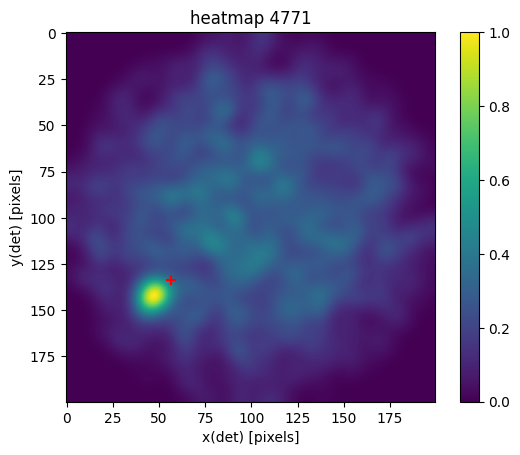

In [19]:
# plot map and prediction  
plot_heatmap(np.fliplr(test_data[idx]), title=f'heatmap {seed}', show=True, add_markers={'SRC': [x, y]})
# plot map and prediction wcs=w, 
#plot_heatmap_wcs(test_data[idx], wcs=w, title=f'heatmap {seed}', show=True, src=sky)

# Plot loss

In [20]:
loss = model.evaluate(test_data, test_labels, verbose=2)

32/32 - 1s - loss: 0.0363 - accuracy: 0.9360 - 909ms/epoch - 28ms/step


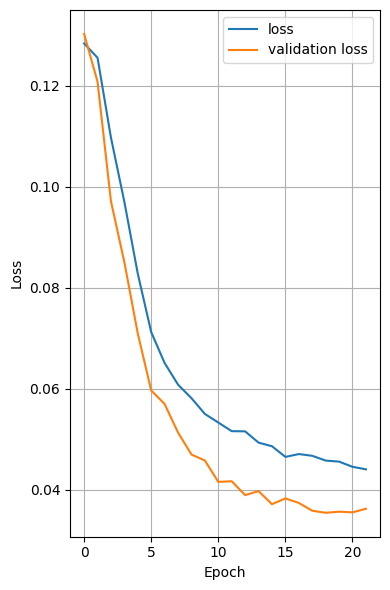

In [22]:
import matplotlib.pyplot as plt

history = np.load(f'/data01/homes/dipiano/astroAI/astroai/models/{savename}_history.npy', 
                  allow_pickle='TRUE').item()


fig, ax = plt.subplots(figsize=(4, 6))

ax.plot(history['loss'], label='loss')
ax.plot(history['val_loss'], label = 'validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#ax.set_ylim([0.2,0.65])
ax.grid()
ax.legend(loc=0)

plt.tight_layout()
plt.show()